In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()

from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tqdm.notebook import tqdm

In [3]:
#intervening fit
i_c = pd.read_csv("intervening_fit.txt", sep='\t')
#intervening fit without nan or inf or -inf
i_c_2 = i_c.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

#getting all the file names which have nan or inf or -inf
all_i = i_c.merge(i_c_2.drop_duplicates(), on = ['Filename'], how='left', indicator=True)
intervening_non_fit = all_i[all_i['_merge'] == 'left_only']
# for i in intervening_non_fit['Filename'].tolist():
#     print(i)

#associated fit
a_c = pd.read_csv("associated_fit.txt", sep='\t')
#associated fit without nan or inf or -inf
a_c_2 = a_c.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

all_a = a_c.merge(a_c_2.drop_duplicates(), on = ['Filename'], how='left', indicator=True)
associated_non_fit_c = all_a[all_a['_merge'] == 'left_only']
# for i in associated_non_fit_c['Filename'].tolist():
#     print(i)

#adding coloumn int or ass to all fits
i_c_2['Class'] = '1'
a_c_2['Class'] = '0'

i_c_2.reset_index(drop=True, inplace=True)
a_c_2.reset_index(drop=True, inplace=True)

tot_fit = pd.concat([a_c_2, i_c_2])
tot_fit

,Filename,Success,Nchan,dof,chi^2,chi^2/dof,rms,A,dA,B_1,...,dX,W_50,dW_50,W_20,dW_20,F_peak,dF_peak,F_int,dF_int,Class
0,0035+22_omd+17.DAT,1,57,49,15.77810,0.322002,0.01,-2.031630e-03,1.606120e-01,0.042972,...,1.623070e+14,13777.40000,2.446390e+16,13777.4000,2.446390e+16,0.000000e+00,0.000000e+00,-2.907700e+00,1.011030e+12,0
1,0105-008_gmrt.freq,1,171,166,11.97330,0.072128,0.01,2.438270e-01,3.728630e+00,0.139187,...,1.250210e+00,15.33200,1.821070e+00,23.9489,2.427310e+00,5.937710e-02,5.261230e-03,9.867140e-01,9.323590e-02,0
2,0941-08_omd+17.DAT,0,63,58,39.50130,0.681057,0.01,2.159550e-02,3.991910e+13,4.699980,...,4.556220e+15,54.25080,4.286510e+16,74.3462,2.616900e+16,2.100440e-02,3.614960e+13,1.148100e+00,1.194950e+15,0
3,101301.DAT,0,154,146,19.94720,0.136625,0.01,2.617700e-03,5.821530e-03,3.801320,...,2.562070e+09,7.34990,1.709560e+09,13.1391,3.578920e+09,1.002560e+11,1.479900e+21,8.763770e+11,1.272970e+22,0
4,1142+052_gmrt.freq,0,87,79,1.09247,0.013829,0.01,3.403460e-03,7.835070e-03,0.362294,...,1.701640e+01,107.43200,3.198280e+01,122.1560,3.922280e+01,6.416640e-03,4.390680e-03,5.615220e-01,2.346570e-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,SPEC_J1438d.DAT,0,505,500,5213.26000,10.426500,0.01,3.138980e-01,8.036160e-02,0.208432,...,1.927660e-01,17.19860,4.745100e-01,25.2765,4.985670e-01,2.772700e-01,5.899940e-03,4.950640e+00,8.794670e-02,1
40,SPEC_J1443.DAT,2,512,507,214.34600,0.422772,0.01,5.226290e+09,2.012170e+12,0.089580,...,3.808220e-01,8.42792,4.144900e-01,13.2778,4.576460e+00,3.339130e-01,1.145490e-01,3.088430e+00,1.815330e-01,1
41,SPEC_J1551.DAT,1,511,506,40849.20000,80.729600,0.01,1.734130e+07,4.822570e+11,7.800820,...,3.799910e+15,-62.12320,7.101660e+15,-107.2050,1.998420e+15,4.079830e+00,3.956260e+09,5.314440e+01,3.009800e+16,1
42,SPEC_J1639.DAT,0,512,504,6577.90000,13.051400,0.01,4.809480e-01,2.592260e-01,0.210122,...,5.206090e-02,23.00760,1.183090e-01,30.3062,2.114130e-01,6.614940e-01,4.192530e-03,1.504510e+01,6.214660e-02,1


In [4]:
tot_fit.columns

Index(['Filename', 'Success', 'Nchan', 'dof', 'chi^2', 'chi^2/dof', 'rms', 'A',
       'dA', 'B_1', 'dB_1', 'B_2', 'dB_2', 'C', 'dC', 'XE_0', 'dXE_0', 'XP_0',
       'dXP_0', 'W', 'dW', 'N', 'dN', 'X', 'dX', 'W_50', 'dW_50', 'W_20',
       'dW_20', 'F_peak', 'dF_peak', 'F_int', 'dF_int', 'Class'],
      dtype='object')

In [5]:
# input
X = tot_fit.iloc[:, [7, 9, 11, 13, 15, 17, 21, 29, 31]].values #excluding 19, 23, 25, 27 columns
# output
y = tot_fit.iloc[:, 33].values.astype('int')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=100, random_state=0)

In [6]:
# checking the scores for zero rule model

score_list = ['roc_auc', 'accuracy', 'average_precision']

steps_dummy = [('over', SMOTE(sampling_strategy=1, random_state=0)), ('model', DummyClassifier(strategy='prior'))]
pipeline_dummy = Pipeline(steps=steps_dummy)
for i in score_list:
    print('{} for SMOTE Model is {}'.format(i, round(np.mean(cross_val_score(pipeline_dummy, X, y, scoring=i, cv=cv, n_jobs=-1)), 3)))

roc_auc for SMOTE Model is 0.5
accuracy for SMOTE Model is 0.618
average_precision for SMOTE Model is 0.382


# Random Forest

In [7]:
steps_rf = [('over', SMOTE(sampling_strategy=1, random_state=0)), ('model', RandomForestClassifier(n_estimators=9, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=10, bootstrap=True, random_state=0))]
pipeline_rf = Pipeline(steps=steps_rf)
for i in score_list:
    print('{} for SMOTE Model is {}'.format(i, round(np.mean(cross_val_score(pipeline_rf, X, y, scoring=i, cv=cv, n_jobs=-1)), 3)))

roc_auc for SMOTE Model is 0.916
accuracy for SMOTE Model is 0.826
average_precision for SMOTE Model is 0.891


In [8]:
param_dist = {
    'model__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'model__max_depth': [1 ,2, 3, 4, 5, 6, 7, 8, 9],
    'model__min_samples_split': [2, 3, 4, 5, 6, 7, 8],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None],
    'model__bootstrap': [True, False]
}

# Get the best hyperparameters from random search
grid_search = GridSearchCV(pipeline_rf, param_grid=param_dist, scoring=score_list, refit='roc_auc', cv=cv, n_jobs=-1, return_train_score=True)
grid_search.fit(X, y)
best_params = grid_search.best_params_
print(best_params)

{'model__bootstrap': True, 'model__max_depth': 2, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__n_estimators': 7}


In [9]:
results_dict = {'Scoring Metric': [], 'Best Parameters': [], 'Best Score': [], 'Parameter Rankings': []}

# Loop over each scoring metric
for scorer in score_list:
    # Store the results for the current scoring metric
    results_dict['Scoring Metric'].append(scorer)
    results_dict['Best Parameters'].append(grid_search.best_params_)
    results_dict['Best Score'].append(grid_search.best_score_)

    # Get the parameter rankings for the scoring metric
    results = grid_search.cv_results_
    params_ranking = results[f'rank_test_{scorer}']
    param_names = results['params']
    param_rankings = [f"Rank {rank}" for rank in params_ranking]

    results_dict['Parameter Rankings'].append(list(zip(param_rankings, param_names)))

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results_dict)

# Print the DataFrame
print(results_df)

      Scoring Metric                                    Best Parameters  \
0            roc_auc  {'model__bootstrap': True, 'model__max_depth':...   
1           accuracy  {'model__bootstrap': True, 'model__max_depth':...   
2  average_precision  {'model__bootstrap': True, 'model__max_depth':...   

   Best Score                                 Parameter Rankings  
0    0.921362  [(Rank 10081, {'model__bootstrap': True, 'mode...  
1    0.921362  [(Rank 9234, {'model__bootstrap': True, 'model...  
2    0.921362  [(Rank 9955, {'model__bootstrap': True, 'model...  


In [18]:
cv_results = pd.DataFrame.from_dict(grid_search.cv_results_)
list(cv_results.columns)
cv_results.to_csv('grid_search_results_rf.csv')

In [19]:
df = cv_results[['params', 'rank_test_roc_auc', 'rank_test_accuracy', 'rank_test_average_precision']]

pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('expand_frame_repr', False)
print(df)
df.to_csv('grid_search_ranks_rf.csv')

                                                  params  rank_test_roc_auc  rank_test_accuracy  rank_test_average_precision
0      {'model__bootstrap': True, 'model__max_depth':...              10081                9234                         9955
1      {'model__bootstrap': True, 'model__max_depth':...              10165                9985                         9927
2      {'model__bootstrap': True, 'model__max_depth':...               8919                9379                         8846
3      {'model__bootstrap': True, 'model__max_depth':...               7489                8509                         7546
4      {'model__bootstrap': True, 'model__max_depth':...               6986                7883                         7059
5      {'model__bootstrap': True, 'model__max_depth':...               7307                8053                         6928
6      {'model__bootstrap': True, 'model__max_depth':...               6683                8373                         6611


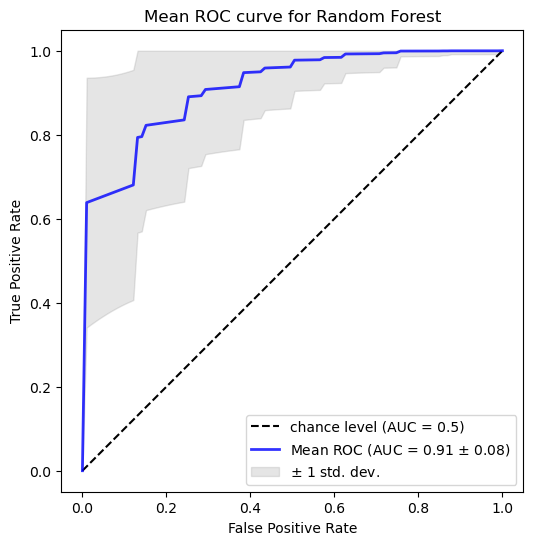

In [6]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = pipeline_rf

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    y_prob = classifier.predict_proba(X[test])[:,1]
    fpr, tpr, _ = roc_curve(y[test], y_prob)
    roc_auc = auc(fpr, tpr)
    # viz = RocCurveDisplay.from_estimator(
    #     classifier,
    #     X[test],
    #     y[test],
    #     #name=f"ROC fold {fold}",
    #     alpha=0.3,
    #     lw=1,
    #     ax=ax,
    # )
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for Random Forest",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:]
labels = labels[:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('./figures_corrected/ROC_curve_random_forest_not_redshift.png')
plt.show()

# XG Boost

In [7]:
steps_xg = [('over', SMOTE(sampling_strategy=1, random_state=0)), ('model', XGBClassifier(subsample=1.0, reg_lambda=0, reg_alpha=1, learning_rate=0.5, gamma=0.3, colsample_bytree=1.0 , n_estimators=9, max_depth=3, random_state=0))]
pipeline_xg = Pipeline(steps=steps_xg)
for i in score_list:
    print('{} for SMOTE Model is {}'.format(i, round(np.mean(cross_val_score(pipeline_xg, X, y, scoring=i, cv=cv, n_jobs=-1)), 3)))

roc_auc for SMOTE Model is 0.96
accuracy for SMOTE Model is 0.891
average_precision for SMOTE Model is 0.95


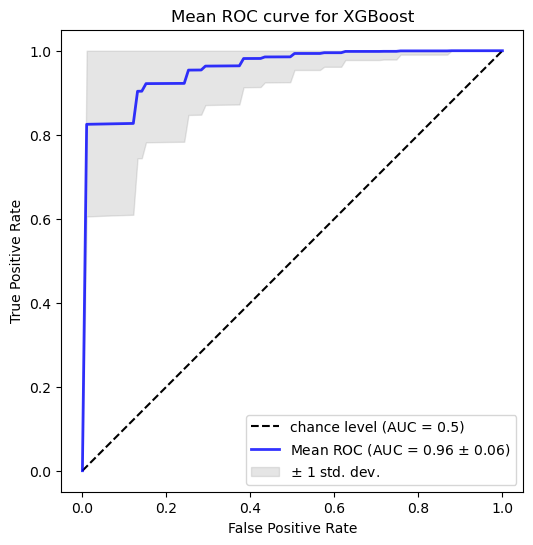

In [8]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = pipeline_xg

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    y_prob = classifier.predict_proba(X[test])[:,1]
    fpr, tpr, _ = roc_curve(y[test], y_prob)
    roc_auc = auc(fpr, tpr)
    # viz = RocCurveDisplay.from_estimator(
    #     classifier,
    #     X[test],
    #     y[test],
    #     #name=f"ROC fold {fold}",
    #     alpha=0.3,
    #     lw=1,
    #     ax=ax,
    # )
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for XGBoost",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:]
labels = labels[:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('./figures_corrected/ROC_curve_XGBoost_not_redshift.png')
plt.show()

# Decision Tree

In [8]:
steps_dt = [('over', SMOTE(sampling_strategy=1, random_state=0)), ('model', DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2 , random_state=0))]
pipeline_dt = Pipeline(steps=steps_dt)
for i in score_list:
    print('{} for DT SMOTE Model is {}'.format(i, round(np.mean(cross_val_score(pipeline_dt, X, y, scoring=i, cv=cv, n_jobs=-1)),3)))

roc_auc for DT SMOTE Model is 0.884
accuracy for DT SMOTE Model is 0.838
average_precision for DT SMOTE Model is 0.813


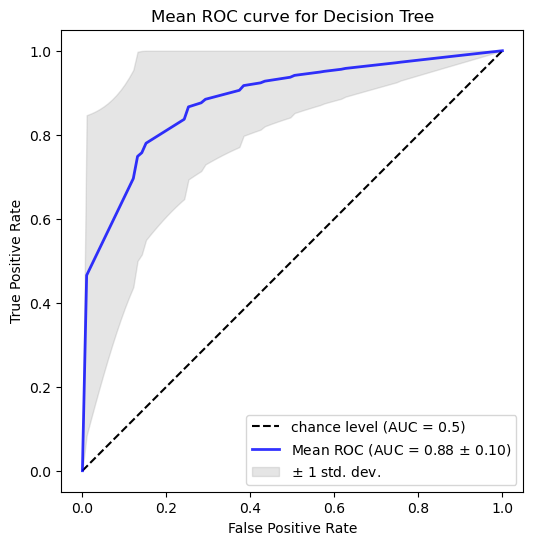

In [10]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = pipeline_dt

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    y_prob = classifier.predict_proba(X[test])[:,1]
    fpr, tpr, _ = roc_curve(y[test], y_prob)
    roc_auc = auc(fpr, tpr)
    # viz = RocCurveDisplay.from_estimator(
    #     classifier,
    #     X[test],
    #     y[test],
    #     #name=f"ROC fold {fold}",
    #     alpha=0.3,
    #     lw=1,
    #     ax=ax,
    # )
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for Decision Tree",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:]
labels = labels[:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('./figures_corrected/ROC_curve_decision_tree_not_redshift.png')
plt.show()

# KNN

In [9]:
steps_knn = [('scaler', StandardScaler()), ('over', SMOTE(sampling_strategy=1, random_state=0)), ('model', KNeighborsClassifier(n_neighbors=13, algorithm='auto', n_jobs=-1, p=1, weights='distance'))]
pipeline_knn = Pipeline(steps=steps_knn)
for i in score_list:
    print('{} for KNN SMOTE Model is {}'.format(i, round(np.mean(cross_val_score(pipeline_knn, X, y, scoring=i, cv=cv, n_jobs=-1)),3)))

roc_auc for KNN SMOTE Model is 0.799
accuracy for KNN SMOTE Model is 0.75
average_precision for KNN SMOTE Model is 0.762


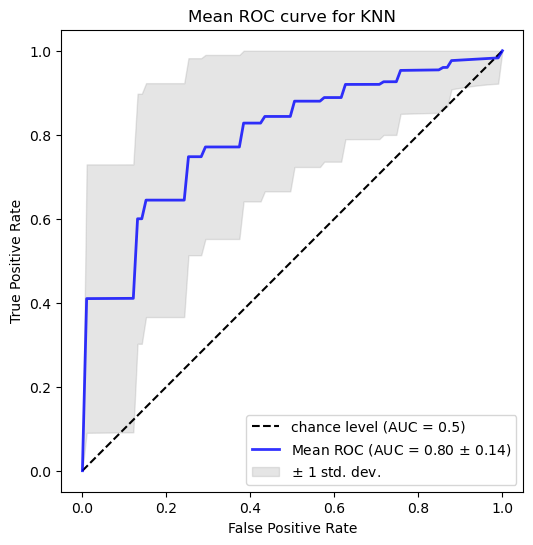

In [12]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = pipeline_knn

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    y_prob = classifier.predict_proba(X[test])[:,1]
    fpr, tpr, _ = roc_curve(y[test], y_prob)
    roc_auc = auc(fpr, tpr)
    # viz = RocCurveDisplay.from_estimator(
    #     classifier,
    #     X[test],
    #     y[test],
    #     #name=f"ROC fold {fold}",
    #     alpha=0.3,
    #     lw=1,
    #     ax=ax,
    # )
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for KNN",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:]
labels = labels[:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('./figures_corrected/ROC_curve_KNN_not_redshift.png')
plt.show()

# SVM

In [10]:
steps_svm = [('scaler', StandardScaler()), ('over', SMOTE(sampling_strategy=1, random_state=0)), ('model', SVC(C = 1, kernel='poly', coef0=0, degree=2, gamma=1, random_state=0, probability=True))]
pipeline_svm = Pipeline(steps=steps_svm)
for i in score_list:
    print('{} for SVM SMOTE Model is {}'.format(i, round(np.mean(cross_val_score(pipeline_svm, X, y, scoring=i, cv=cv, n_jobs=-1)),3)))

roc_auc for SVM SMOTE Model is 0.792
accuracy for SVM SMOTE Model is 0.733
average_precision for SVM SMOTE Model is 0.765


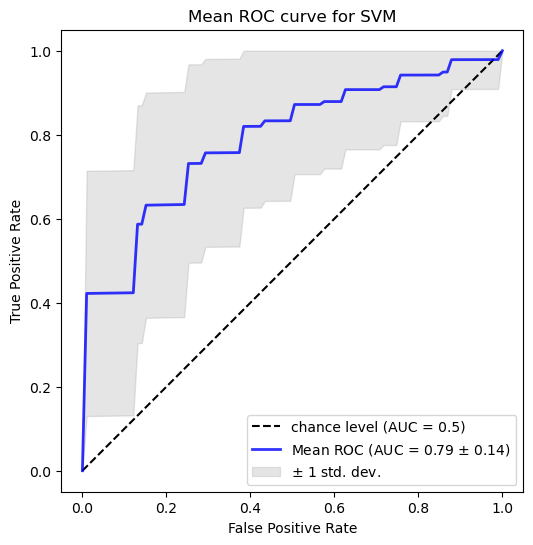

In [14]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = pipeline_svm

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    y_prob = classifier.predict_proba(X[test])[:,1]
    fpr, tpr, _ = roc_curve(y[test], y_prob)
    roc_auc = auc(fpr, tpr)
    # viz = RocCurveDisplay.from_estimator(
    #     classifier,
    #     X[test],
    #     y[test],
    #     #name=f"ROC fold {fold}",
    #     alpha=0.3,
    #     lw=1,
    #     ax=ax,
    # )
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for SVM",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:]
labels = labels[:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('./figures_corrected/ROC_curve_SVM_not_redshift.png')
plt.show()

# Logistic Regression

In [11]:
steps_lr = [('scaler', StandardScaler()), ('over', SMOTE(sampling_strategy=1, random_state=0)), ('model', LogisticRegressionCV(max_iter=300, Cs= 100, penalty='l2', random_state=0, solver='liblinear', n_jobs=-1))]
pipeline_lr = Pipeline(steps=steps_lr)
for i in score_list:
    print('{} for LR SMOTE Model is {}'.format(i, round(np.mean(cross_val_score(pipeline_lr, X, y, scoring=i, cv=cv, n_jobs=-1)),3)))

roc_auc for LR SMOTE Model is 0.528
accuracy for LR SMOTE Model is 0.469
average_precision for LR SMOTE Model is 0.56


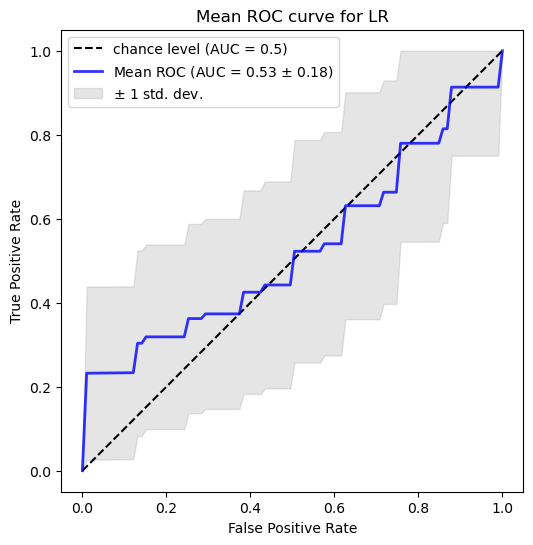

In [20]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = pipeline_lr

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    y_prob = classifier.predict_proba(X[test])[:,1]
    fpr, tpr, _ = roc_curve(y[test], y_prob)
    roc_auc = auc(fpr, tpr)
    # viz = RocCurveDisplay.from_estimator(
    #     classifier,
    #     X[test],
    #     y[test],
    #     #name=f"ROC fold {fold}",
    #     alpha=0.3,
    #     lw=1,
    #     ax=ax,
    # )
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for LR",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:]
labels = labels[:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('./figures_corrected/ROC_curve_LR_not_redshift.png')
plt.show()

# Ensemble

In [12]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[('XG Boost', pipeline_xg),
                                        ('Random Forest', pipeline_rf),
                                        ('Decision Tree', pipeline_dt),
                                        ('KNN', pipeline_knn),
                                        ('SVM', pipeline_svm),
                                        ('Logistic Regression', pipeline_lr)],
                             voting='soft', n_jobs=-1)

for i in score_list:
    print('{} for SVM SMOTE Model is {}'.format(i, round(np.mean(cross_val_score(ensemble, X, y, scoring=i, cv=cv, n_jobs=-1)),3)))

roc_auc for SVM SMOTE Model is 0.951
accuracy for SVM SMOTE Model is 0.875
average_precision for SVM SMOTE Model is 0.936


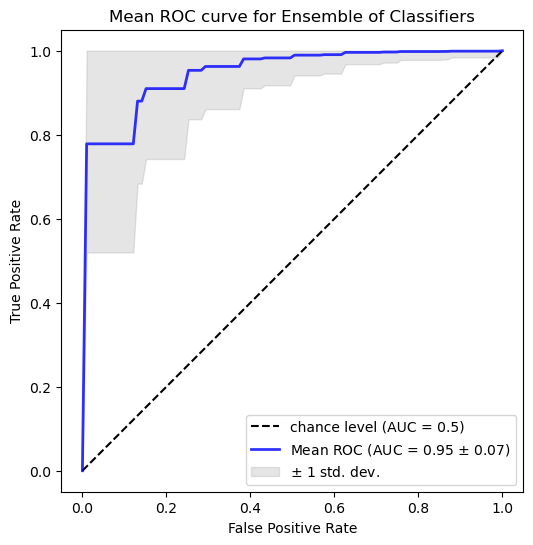

In [13]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = ensemble

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    y_prob = classifier.predict_proba(X[test])[:,1]
    fpr, tpr, _ = roc_curve(y[test], y_prob)
    roc_auc = auc(fpr, tpr)
    # viz = RocCurveDisplay.from_estimator(
    #     classifier,
    #     X[test],
    #     y[test],
    #     #name=f"ROC fold {fold}",
    #     alpha=0.3,
    #     lw=1,
    #     ax=ax,
    # )
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for Ensemble of Classifiers",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:]
labels = labels[:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('./figures_corrected/ensemble_not_redshift.png')
plt.show()

# All model accuracy in a plot

In [21]:
def mse_array(x):
    return np.mean((x - np.mean(x)) ** 2, dtype=float)

In [22]:
model1_scores = mse_array(cross_val_score(pipeline_rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
model2_scores = mse_array(cross_val_score(pipeline_dt, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
model3_scores = mse_array(cross_val_score(pipeline_svm, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
model4_scores = mse_array(cross_val_score(pipeline_xg, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
model5_scores = mse_array(cross_val_score(pipeline_knn, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
model6_scores = mse_array(cross_val_score(pipeline_lr, X, y, scoring='accuracy', cv=cv, n_jobs=-1))

print(model1_scores, model2_scores, model3_scores, model4_scores, model5_scores, model6_scores)

0.011883011793228138 0.01118234714003945 0.01490641021531887 0.008422991288625906 0.01429558366206443 0.01858398668639053


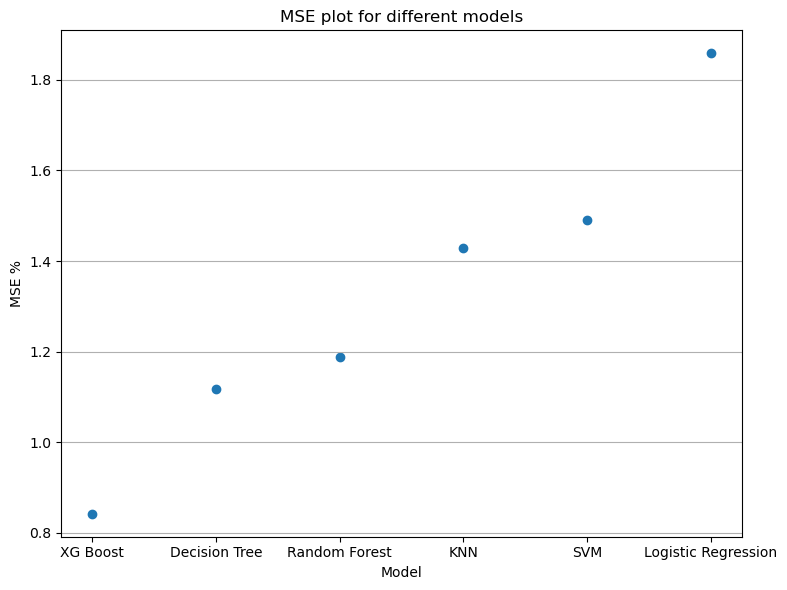

In [23]:
class_labels = ['XG Boost', 'Decision Tree', 'Random Forest', 'KNN', 'SVM', 'Logistic Regression']
all_scores = [model4_scores*100, model2_scores*100, model1_scores*100, model5_scores*100, model3_scores*100, model6_scores*100]

# Create histogram plot
fig, ax = plt.subplots(figsize=(8, 6))


ax.scatter(class_labels, all_scores, alpha=1)

ax.set_xlabel('Model')
ax.set_ylabel('MSE %')
ax.set_title('MSE plot for different models')

ax.yaxis.grid(True)

fig.tight_layout()

plt.savefig('./figures_corrected/mse_plot_fig_all_machine_learning_models_not_redshift.png')
plt.show()